In [ ]:
import sys
from itertools import groupby
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from tqdm import tqdm

In [ ]:
# Конфигурация
epochs = 10
num_classes = 11
blank_label = 10
image_height = 28
gru_hidden_size = 256
gru_num_layers = 2
min_seq_length = 5
max_seq_length = 10
number_of_sequences = 10000

In [ ]:
# Кастомный collate_fn для обработки переменной длины
def collate_fn(batch):
    images, labels = zip(*batch)
    max_width = max(img.shape[2] for img in images)

    padded_images = []
    for img in images:
        pad = max_width - img.shape[2]
        padded = F.pad(img, (0, pad), value=0)
        padded_images.append(padded)

    return torch.stack(padded_images), [torch.IntTensor(l) for l in labels]

# Генерация данных
emnist_dataset = datasets.EMNIST('./EMNIST', split="digits", train=True, download=True)

100%|██████████| 562M/562M [00:31<00:00, 17.6MB/s]


Extracting ./EMNIST/EMNIST/raw/gzip.zip to ./EMNIST/EMNIST/raw


In [ ]:
class SequenceDataset(data_utils.Dataset):
    def __init__(self):
        self.sequences = []
        self.labels = []

        for _ in range(number_of_sequences):
            seq_length = np.random.randint(min_seq_length, max_seq_length+1)
            indices = np.random.randint(len(emnist_dataset.data), size=seq_length)
            imgs = emnist_dataset.data[indices]
            labels = emnist_dataset.targets[indices]

            processed_imgs = []
            for img in imgs:
                img = transforms.ToPILImage()(img)
                img = TF.rotate(img, -90, fill=0)
                img = TF.hflip(img)
                img = transforms.RandomAffine(degrees=5, translate=(0.1, 0.1))(img)
                img = transforms.ToTensor()(img)
                processed_imgs.append(img)

            sequence = torch.cat(processed_imgs, dim=2)
            self.sequences.append(sequence)
            self.labels.append(labels.numpy())

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [ ]:
# Инициализация данных
dataset = SequenceDataset()
train_set, val_set = data_utils.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])

train_loader = data_utils.DataLoader(
    train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = data_utils.DataLoader(
    val_set, batch_size=10, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Модель CRNN с динамическим расчетом параметров
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()

        # CNN Layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(),

            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # 14xW
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # 7x(W/2)
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(),
        )

        # Динамический расчет входного размера GRU
        self.gru_input_size = 64 * 7  # 64 канала * 7 (высота после CNN)

        # GRU Layer
        self.gru = nn.GRU(
            input_size=self.gru_input_size,
            hidden_size=gru_hidden_size,
            num_layers=gru_num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Fully Connected
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        # CNN
        x = self.cnn(x)  # [B, C=64, H=7, W]

        # Подготовка для GRU
        B, C, H, W = x.size()
        x = x.permute(0, 3, 2, 1)  # [B, W, H, C]
        x = x.reshape(B, W, H * C)  # [B, W, H*C=448]

        # GRU
        x, _ = self.gru(x)  # [B, W, hidden_size*2]

        # Output
        x = self.fc(x)  # [B, W, num_classes]
        return F.log_softmax(x, dim=2)


# Тестовый запуск
test_input = torch.randn(2, 1, 28, 140)  # Batch=2, Height=28, Width=140
model = CRNN()
output = model(test_input)
print(output.shape)  # [2, 140, 11] - корректно

torch.Size([2, 35, 11])


In [ ]:
model = CRNN().cuda()
criterion = nn.CTCLoss(blank=blank_label, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Обучение
for epoch in range(epochs):
    model.train()
    total_loss = 0
    char_correct = 0
    total_chars = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x = x.cuda()
        optimizer.zero_grad()

        outputs = model(x).permute(1, 0, 2)
        input_lengths = torch.IntTensor([outputs.size(0)]*x.size(0)).cuda()
        target_lengths = torch.IntTensor([len(t) for t in y]).cuda()

        loss = criterion(outputs, torch.cat(y).cuda(), input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        # Метрики
        _, preds = torch.max(outputs, 2)
        for i in range(len(y)):
            pred = [k for k, _ in groupby(preds[:,i].tolist()) if k != blank_label]
            true = y[i].tolist()
            min_len = min(len(pred), len(true))
            char_correct += sum(p == t for p, t in zip(pred[:min_len], true[:min_len]))
            total_chars += len(true)

    # Валидация
    model.eval()
    val_results = []
    with torch.no_grad():
        for x, y in val_loader:
            outputs = model(x.cuda()).permute(1, 0, 2)
            _, preds = torch.max(outputs, 2)
            for i in range(len(y)):
                pred = [k for k, _ in groupby(preds[:,i].tolist()) if k != blank_label]
                val_results.append((pred, y[i].tolist()))

    seq_acc = sum(np.array_equal(p, t) for p, t in val_results)/len(val_results)
    char_acc = sum(sum(p == t for p, t in zip(p, t)) for p, t in val_results)/sum(len(t) for t in val_results)

    print(f"Epoch {epoch+1}")
    print(f"Seq Acc: {seq_acc:.2%} | Char Acc: {char_acc:.2%}")
    print("-"*50)
    print(f"Seq Acc: {seq_acc:.2%} | Char Acc: {char_acc:.2%}")
    print("-"*50)

Epoch 1: 100%|██████████| 125/125 [00:08<00:00, 15.25it/s]


Epoch 1
Seq Acc: 51.70% | Char Acc: 307.60%
--------------------------------------------------
Seq Acc: 51.70% | Char Acc: 307.60%
--------------------------------------------------


Epoch 2: 100%|██████████| 125/125 [00:06<00:00, 18.86it/s]


Epoch 2
Seq Acc: 84.60% | Char Acc: 360.65%
--------------------------------------------------
Seq Acc: 84.60% | Char Acc: 360.65%
--------------------------------------------------


Epoch 3: 100%|██████████| 125/125 [00:06<00:00, 18.58it/s]


Epoch 3
Seq Acc: 90.10% | Char Acc: 364.98%
--------------------------------------------------
Seq Acc: 90.10% | Char Acc: 364.98%
--------------------------------------------------


Epoch 4: 100%|██████████| 125/125 [00:06<00:00, 18.43it/s]


Epoch 4
Seq Acc: 90.55% | Char Acc: 366.02%
--------------------------------------------------
Seq Acc: 90.55% | Char Acc: 366.02%
--------------------------------------------------


Epoch 5: 100%|██████████| 125/125 [00:06<00:00, 18.55it/s]


Epoch 5
Seq Acc: 92.50% | Char Acc: 366.80%
--------------------------------------------------
Seq Acc: 92.50% | Char Acc: 366.80%
--------------------------------------------------


Epoch 6: 100%|██████████| 125/125 [00:06<00:00, 18.16it/s]


Epoch 6
Seq Acc: 93.85% | Char Acc: 367.90%
--------------------------------------------------
Seq Acc: 93.85% | Char Acc: 367.90%
--------------------------------------------------


Epoch 7: 100%|██████████| 125/125 [00:07<00:00, 17.72it/s]


Epoch 7
Seq Acc: 93.10% | Char Acc: 367.35%
--------------------------------------------------
Seq Acc: 93.10% | Char Acc: 367.35%
--------------------------------------------------


Epoch 8: 100%|██████████| 125/125 [00:06<00:00, 18.23it/s]


Epoch 8
Seq Acc: 94.00% | Char Acc: 368.00%
--------------------------------------------------
Seq Acc: 94.00% | Char Acc: 368.00%
--------------------------------------------------


Epoch 9: 100%|██████████| 125/125 [00:07<00:00, 17.85it/s]


Epoch 9
Seq Acc: 93.50% | Char Acc: 367.72%
--------------------------------------------------
Seq Acc: 93.50% | Char Acc: 367.72%
--------------------------------------------------


Epoch 10: 100%|██████████| 125/125 [00:06<00:00, 17.96it/s]


Epoch 10
Seq Acc: 93.80% | Char Acc: 368.15%
--------------------------------------------------
Seq Acc: 93.80% | Char Acc: 368.15%
--------------------------------------------------


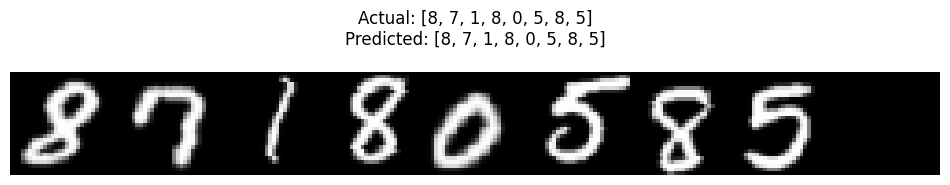

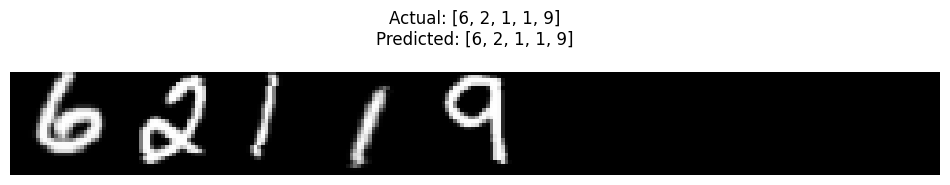

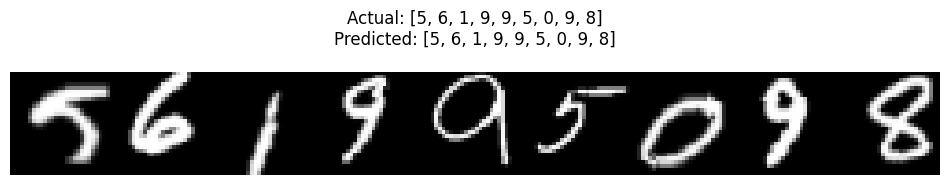

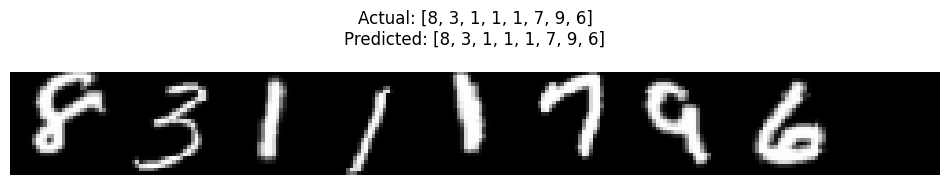

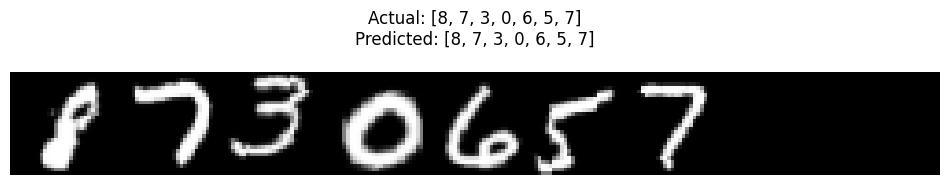

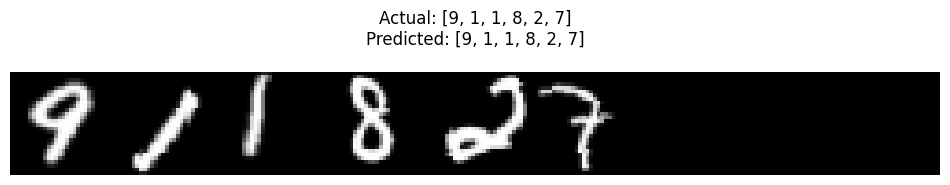

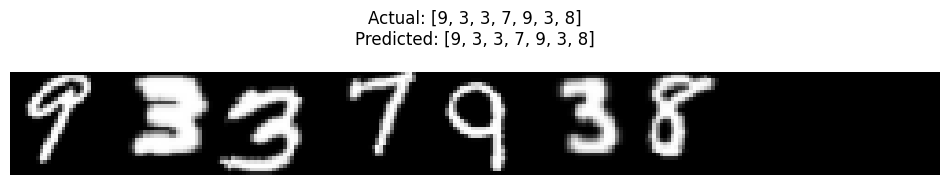

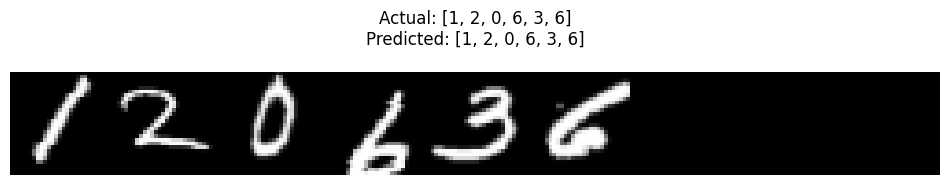

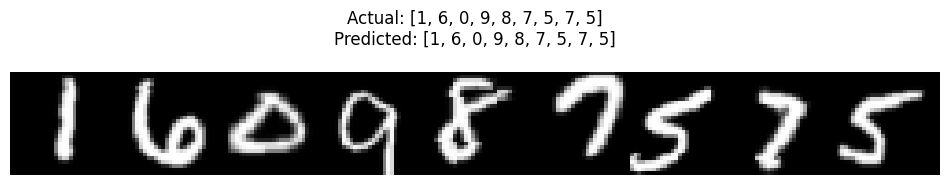

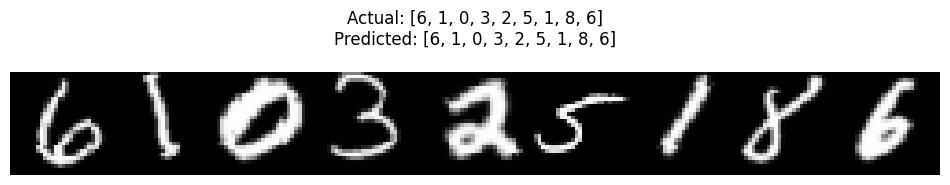

In [ ]:
# Визуализация
model.eval()
with torch.no_grad():
    x, y = next(iter(val_loader))
    outputs = model(x.cuda()).permute(1, 0, 2)
    _, preds = torch.max(outputs, 2)

    for i in range(10):
        img = x[i].squeeze()
        true = y[i].tolist()
        pred = [k for k, _ in groupby(preds[:,i].tolist()) if k != blank_label]

        plt.figure(figsize=(12, 3))
        plt.imshow(img, cmap='gray')
        plt.title(f"Actual: {true}\nPredicted: {pred}", pad=20)
        plt.axis('off')
        plt.show()

well-done

In [ ]:
pip install jiwer

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from itertools import groupby
from jiwer import wer, cer

# Accuracy function with CER and WER
def calculate_metrics(preds, targets):
    pred_strs = ["".join(map(str, p)) for p in preds]
    target_strs = ["".join(map(str, t)) for t in targets]

    cer_score = cer(target_strs, pred_strs)
    wer_score = wer(target_strs, pred_strs)

    return cer_score, wer_score

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x = x.cuda()
        optimizer.zero_grad()

        outputs = model(x).permute(1, 0, 2)
        input_lengths = torch.IntTensor([outputs.size(0)] * x.size(0)).cuda()
        target_lengths = torch.IntTensor([len(t) for t in y]).cuda()

        loss = criterion(outputs, torch.cat(y).cuda(), input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_results = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, y in val_loader:
            outputs = model(x.cuda()).permute(1, 0, 2)
            _, preds = torch.max(outputs, 2)
            for i in range(len(y)):
                pred = [k for k, _ in groupby(preds[:, i].tolist()) if k != blank_label]
                val_results.append((pred, y[i].tolist()))
                all_preds.append(pred)
                all_targets.append(y[i].tolist())

    # Compute CER and WER
    cer_score, wer_score = calculate_metrics(all_preds, all_targets)
    print(f"Epoch {epoch+1}: Loss: {total_loss:.4f}, CER: {cer_score:.4f}, WER: {wer_score:.4f}")


Epoch 1: Loss: 0.3940, CER: 0.0080, WER: 0.0585
Epoch 2: Loss: 0.1518, CER: 0.0067, WER: 0.0495
Epoch 3: Loss: 0.0937, CER: 0.0063, WER: 0.0460
Epoch 4: Loss: 0.0514, CER: 0.0063, WER: 0.0460
Epoch 5: Loss: 0.0398, CER: 0.0061, WER: 0.0445
Epoch 6: Loss: 0.0333, CER: 0.0061, WER: 0.0450
Epoch 7: Loss: 0.0274, CER: 0.0059, WER: 0.0435
Epoch 8: Loss: 0.0189, CER: 0.0060, WER: 0.0440
Epoch 9: Loss: 0.0162, CER: 0.0061, WER: 0.0445
Epoch 10: Loss: 0.0143, CER: 0.0061, WER: 0.0450


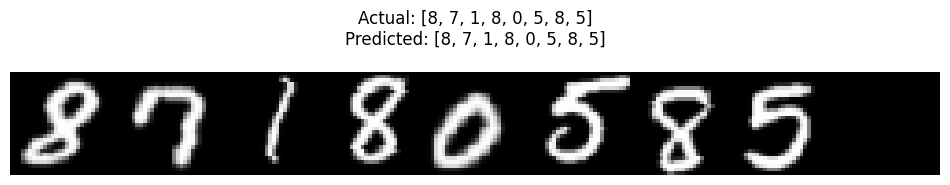

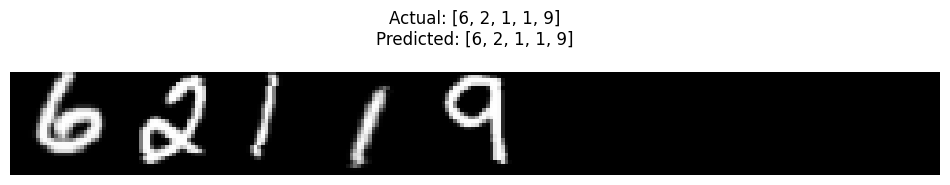

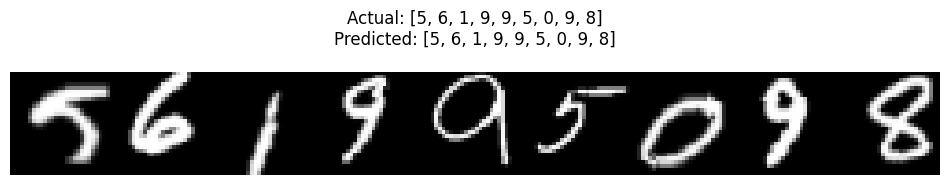

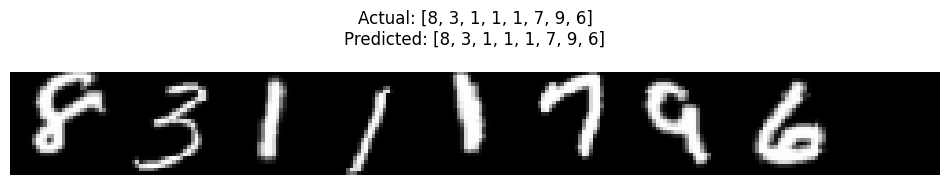

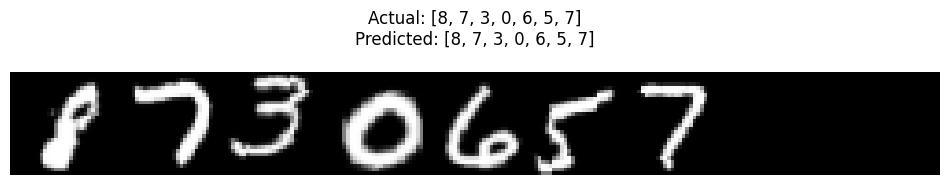

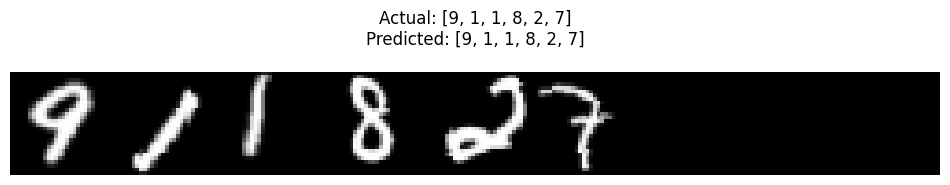

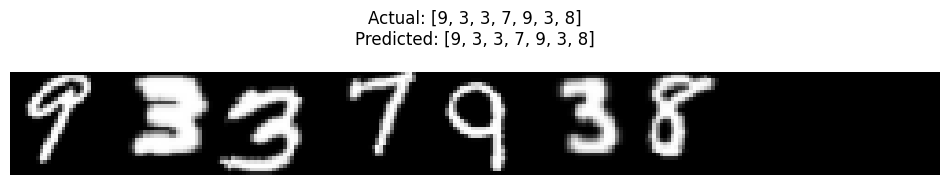

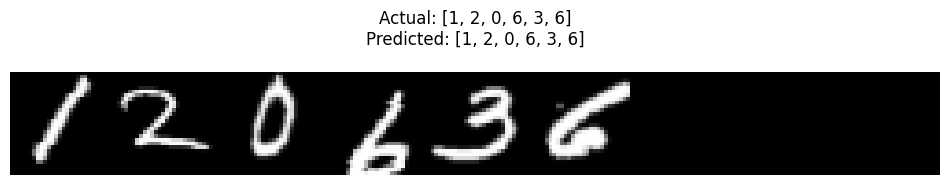

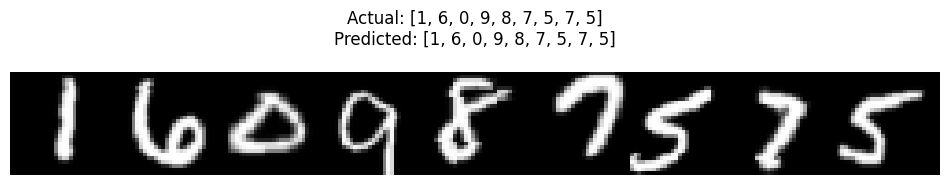

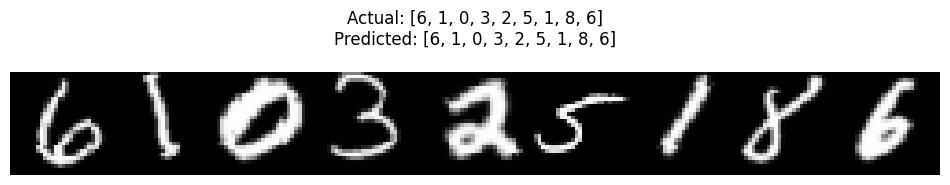

CER: 0.0000, WER: 0.0000


In [ ]:
import matplotlib.pyplot as plt

# Визуализация с CER и WER
model.eval()
with torch.no_grad():
    x, y = next(iter(val_loader))
    outputs = model(x.cuda()).permute(1, 0, 2)
    _, preds = torch.max(outputs, 2)

    all_preds = []
    all_targets = []

    for i in range(10):  # Визуализируем 10 примеров
        img = x[i].squeeze()
        true = y[i].tolist()
        pred = [k for k, _ in groupby(preds[:, i].tolist()) if k != blank_label]

        all_preds.append(pred)
        all_targets.append(true)

        plt.figure(figsize=(12, 3))
        plt.imshow(img, cmap='gray')
        plt.title(f"Actual: {true}\nPredicted: {pred}", pad=20)
        plt.axis('off')
        plt.show()

    # Вычисляем CER и WER для этих 10 примеров
    cer_score, wer_score = calculate_metrics(all_preds, all_targets)
    print(f"CER: {cer_score:.4f}, WER: {wer_score:.4f}")